# Aphid-Ladybeetle study

## Obtaining Initial Conditions

We need to define Initial Conditions as functions in order to define them for each discretization point. Here we will fit ICs as polynomial functions.

Loading data:

In [1]:
import pandas as pd

aphid_data = pd.read_csv('../data/aphid.csv')
ladybeetle_data = pd.read_csv('../data/ladybeetle.csv')

In [2]:
aphid_data

,variable,time,x,density
0,aphid,0,1.0,19.834058
1,aphid,0,2.0,70.841565
2,aphid,0,3.0,264.045832
3,aphid,0,4.0,620.308179
4,aphid,0,5.0,434.176215
5,aphid,0,6.0,96.918214
6,aphid,0,7.0,38.285263
7,aphid,0,8.0,15.211379
8,aphid,1,1.0,11.940299
9,aphid,1,2.0,74.626866


Retrieving IC data:

In [3]:
aphid_ic_data = aphid_data[aphid_data.time == 0].copy()
ladybeetle_ic_data = ladybeetle_data[ladybeetle_data.time == 0].copy()

In [4]:
aphid_ic_data

,variable,time,x,density
0,aphid,0,1.0,19.834058
1,aphid,0,2.0,70.841565
2,aphid,0,3.0,264.045832
3,aphid,0,4.0,620.308179
4,aphid,0,5.0,434.176215
5,aphid,0,6.0,96.918214
6,aphid,0,7.0,38.285263
7,aphid,0,8.0,15.211379


In [5]:
ladybeetle_ic_data

,variable,time,x,density
0,ladybeetle,0,1.0,2.791089
1,ladybeetle,0,2.0,2.734275
2,ladybeetle,0,3.0,2.697629
3,ladybeetle,0,4.0,2.617913
4,ladybeetle,0,5.0,2.686136
5,ladybeetle,0,6.0,2.669769
6,ladybeetle,0,7.0,2.655327
7,ladybeetle,0,8.0,2.638960


### Ladybird beetles IC

For ladybird beetles is quite simple, we just need to take the mean:

In [6]:
ladybeetle_ic = ladybeetle_ic_data.density.values.mean()

ladybeetle_ic

2.6863873510629865

### Aphids IC

This is a more interesting case. Let's have a look on the points.

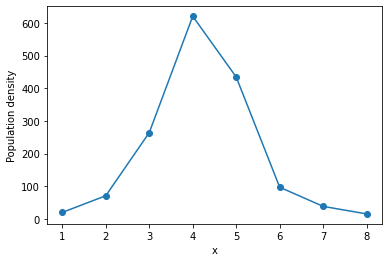

In [7]:
import matplotlib.pyplot as plt

plt.plot(aphid_ic_data.x.values, aphid_ic_data.density.values, '-o')
plt.xlabel('x')
plt.ylabel('Population density')
plt.show()

It quite resembles a gaussian. So let us fit a gaussian to it.

* Define a gaussian function:

In [8]:
import numpy as np
from typing import Union

def gaussian(
    x: Union[float, np.ndarray],
    scale_term: float,
    mu: float, 
    sigma: float
) -> Union[float, np.ndarray]:
    """
    A univariate gaussian function.
    
    :param x:
        The value to evaluate the gaussian function.
        
    :param scale_term:
        The proportional term that multiplicates the gaussian exponential
        term.
        
    :param mu:
        The mean for the gaussian function.
        
    :param sigma:
        The standard deviation.
        
    :return:
        A value, or an array of values, computed with the gaussian function.
    """
    exponential_term = np.exp(- 1.0 / 2.0 * ((x - mu) / sigma) ** 2.0)
    return scale_term * exponential_term

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [9]:
def calculate_least_squares_error(parameters, x_data, y_data, fitting_model):
    args = parameters
    y_model = fitting_model(x_data, *args)    
    residual = y_data - y_model
    return np.sum(residual ** 2.0)

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [10]:
from scipy import optimize


def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')
    

parameters_bounds = [(1e-5, 1000), (1e-5, 10), (1e-5, 1000)]
x_data = aphid_ic_data.x.values
y_data = aphid_ic_data.density.values
seed = 1234  # for the sake of reproducibility

result= optimize.differential_evolution(
    calculate_least_squares_error, 
    bounds=parameters_bounds, 
    args=(x_data, y_data, gaussian), 
    popsize=30,
    strategy='best1bin',
    tol=1e-8,
    recombination=0.7,
    maxiter=500,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
)

print(result)

differential_evolution step 1: f(x)= 355463
parameters = [195.63549367   5.37033824 643.01581751]

differential_evolution step 2: f(x)= 355451
parameters = [194.74637253   3.13392236 362.68744169]

differential_evolution step 3: f(x)= 354818
parameters = [195.29219431   4.40594159  42.91756473]

differential_evolution step 4: f(x)= 352767
parameters = [182.99086019   1.02139934  17.35647956]

differential_evolution step 5: f(x)= 350106
parameters = [214.03042632   1.80148122  15.52827362]

differential_evolution step 6: f(x)= 348893
parameters = [214.03042632   3.23636905  13.19985252]

differential_evolution step 7: f(x)= 281021
parameters = [222.70448192   3.09557883   2.39930845]

differential_evolution step 8: f(x)= 257213
parameters = [224.61756075   3.54746467   2.73455639]

differential_evolution step 9: f(x)= 257213
parameters = [224.61756075   3.54746467   2.73455639]

differential_evolution step 10: f(x)= 257213
parameters = [224.61756075   3.54746467   2.73455639]

different

* Retrieving the calibrated parameter values:

In [11]:
scale_term, mu, sigma = result.x

x = np.linspace(0, 9)
aphid_ic_points = gaussian(x, scale_term, mu, sigma)

* Plotting the fitted function to compare with data:

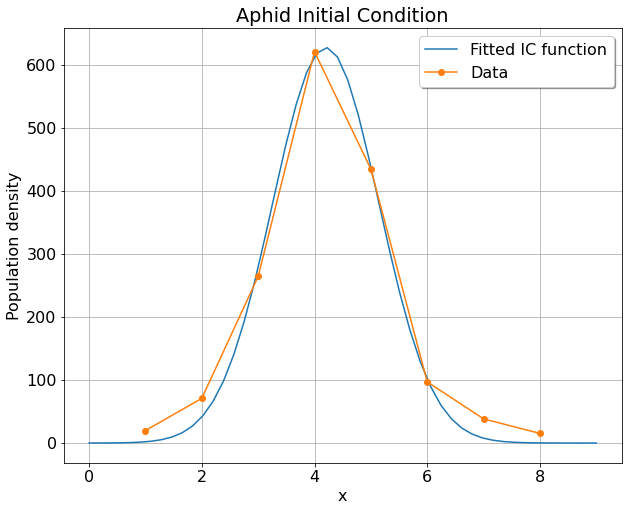

In [12]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})

plt.plot(x, aphid_ic_points, '-', label='Fitted IC function')
plt.plot(aphid_ic_data.x.values, aphid_ic_data.density.values, '-o', label='Data')

plt.title('Aphid Initial Condition')
plt.xlabel('x')
plt.ylabel('Population density')

plt.grid(True)
plt.legend(fancybox=True, shadow=True)

plt.savefig('fitted_ic.png', dpi=300)
plt.show()

## First model: classical Lotka-Volterra

The problem consists in solving the system:

\begin{equation}
\begin{aligned}
u_{t} &=D_{u} u_{x x}+f(u, v) \\
v_{t} &=D_{v} v_{x x}+g(u, v)
\end{aligned}
\end{equation}

in which $u$ is the prey and $v$ the predator, $D_u$ and $D_v$ are the diffusive coefficients, and $f(u, v)$ and $g(u, v)$ are the reactive terms that can have the following form:

\begin{equation}
\begin{array}{c}
f(u, v)=r u-a u v \\
g(u, v)=b a u v-m v
\end{array}
\end{equation}

with the constants $r, a, b, m > 0$.


### Forward simulation

In [13]:
from pde import (PDE, FieldCollection, PlotTracker, ScalarField, UnitGrid, 
                 CartesianGrid, MemoryStorage)
from pde import ExplicitSolver, ImplicitSolver, Controller, ScipySolver

# Species diffusivity coefficients (please be careful with these values)
Du = 0.67e-3  # gathered from Banks
Dv = 0.21e-2  # gathered from Banks

# Banks functional response 1 (case A)
r1 = 0.136
r2 = 0.48e-3
p = 0.032
i = 11.0
e1 = 0.0012
e2 = 20.9
e3 = 0.009

# Functional response (case A)
f_function = f"+ {r1} * u - {r2} * u * u - {p} * u * v"  # don't forget to put + (or -) sign in the beginning
g_function = f"+ {i} - ({e1} + {e2} * exp(- {e3} * u)) * v"

# (Dirichlet) Boundary condition example
bc_left = {"value": 0.0}  # both unknowns are set to zero, unfortunately
bc_right = {"value": 0.0}
bc = [bc_left, bc_right]

# Definition of PDE system
eq = PDE(
    {
        "u": f"{Du} * laplace(u)" + f_function,
        "v": f"{Dv} * laplace(v)" + g_function,
    },
    bc=bc  # comment here if you want to "free" the boundaries
)

# Defining the mesh
x_min, x_max = 0, 9
dx = 0.2
num_points_in_x = int((x_max - x_min) / dx)
grid = CartesianGrid(bounds=[[x_min, x_max]], shape=num_points_in_x)

# Initialize state (Initial Conditions)
u = ScalarField.from_expression(
    grid, 
    f"{scale_term} * exp(- 1.0 / 2.0 * ((x - {mu}) / {sigma}) ** 2.0)", 
    label="Prey"
)
v = ScalarField(grid, ladybeetle_ic, label="Predator")
state = FieldCollection([u, v])  # state vector

# Define time tracker to plot and animate
x_axis_limits = (x_min, x_max)
y_axis_limits = (0, 650)
tracker_plot_config = PlotTracker(show=True, plot_args={
        'ax_style': {'xlim': x_axis_limits, 'ylim': y_axis_limits},
    }
)
storage = MemoryStorage()
dt = 1e-5
trackers = [
    "progress",  # show progress bar during simulation
    "steady_state",  # abort if steady state is reached
    storage.tracker(interval=1),  # store data every simulation time unit
    tracker_plot_config,  # show images during simulation
]

# Select backend solver
# solver = ExplicitSolver(eq)  # Built-in explicit solver
solver = ScipySolver(eq, method='LSODA')  # SciPy solver

# Setup solver
controller = Controller(solver, t_range=[0, 2], tracker=trackers)
solve = controller.run(state, dt=dt)

Output()

Spent more time on handling trackers (1.9485479569999962) than on the actual simulation (1.750811136000003)


Retrieving data stored spaced by 1.0 as time-records:

In [14]:
u_storage = storage.extract_field(0)
v_storage = storage.extract_field(1)

u_storage.data

[array([4.91157199e-02, 1.20790118e-01, 2.83989210e-01, 6.38310255e-01,
        1.37158065e+00, 2.81754216e+00, 5.53323408e+00, 1.03883652e+01,
        1.86455381e+01, 3.19935313e+01, 5.24818314e+01, 8.23029365e+01,
        1.23390358e+02, 1.76850653e+02, 2.42321336e+02, 3.17421389e+02,
        3.97502868e+02, 4.75887055e+02, 5.44661982e+02, 5.95949938e+02,
        6.23378818e+02, 6.23381414e+02, 5.95957383e+02, 5.44673323e+02,
        4.75900928e+02, 3.97517767e+02, 3.17435930e+02, 2.42334455e+02,
        1.76861700e+02, 1.23399094e+02, 8.23094489e+01, 5.24864213e+01,
        3.19965959e+01, 1.86474794e+01, 1.03895333e+01, 5.53390237e+00,
        2.81790593e+00, 1.37176916e+00, 6.38403300e-01, 2.84032972e-01,
        1.20809737e-01, 4.91241068e-02, 1.90961994e-02, 7.09673779e-03,
        2.52133251e-03]),
 array([5.46788748e-02, 1.37333679e-01, 3.22414892e-01, 7.23536953e-01,
        1.55198773e+00, 3.18122921e+00, 6.22886051e+00, 1.16427797e+01,
        2.07553624e+01, 3.52407553e+01

Retrieving mesh coordinates:

In [15]:
x_points = grid.axes_coords[0]

x_points

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9, 5.1,
       5.3, 5.5, 5.7, 5.9, 6.1, 6.3, 6.5, 6.7, 6.9, 7.1, 7.3, 7.5, 7.7,
       7.9, 8.1, 8.3, 8.5, 8.7, 8.9])

### Comparing simulation with measurements

In [16]:
time_labels_dict = {
    0: 0,
    1: 2,
    2: 3
}

#### Aphids

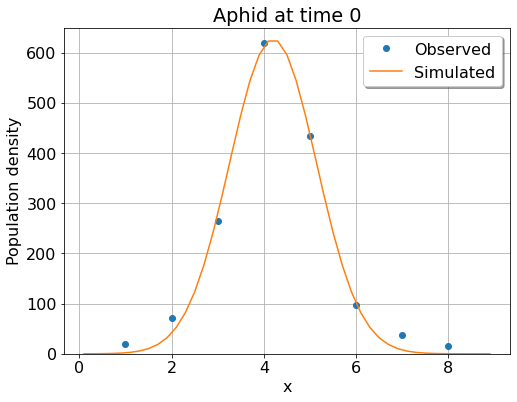

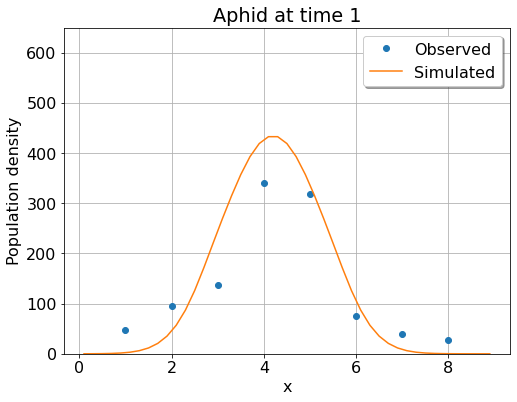

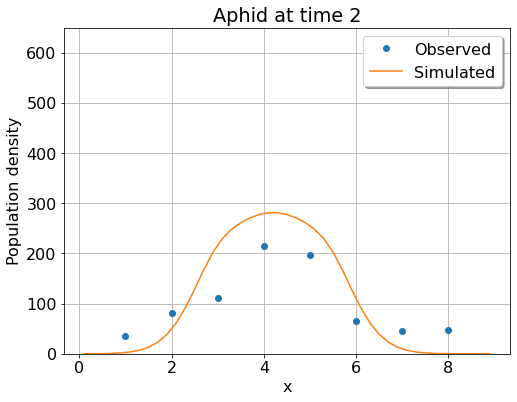

In [17]:
for time_index, aphid_simulation in enumerate(u_storage.data):
    plt.figure(figsize=(8, 6))
    plt.ylim([0, 650])
    
    idx_for_observed = time_labels_dict[time_index]  # we skip time 1/4
    aphid_observed = aphid_data[aphid_data.time == idx_for_observed].copy()
    plt.plot(aphid_observed.x.values, aphid_observed.density.values, 'o', label='Observed')
    plt.plot(x_points, aphid_simulation, '-', label='Simulated')
    
    plt.xlabel('x')
    plt.ylabel('Population density')
    plt.title(f'Aphid at time {time_index}')
    
    plt.grid(True)
    plt.legend(shadow=True)
    plt.show()

#### Ladybird beetles

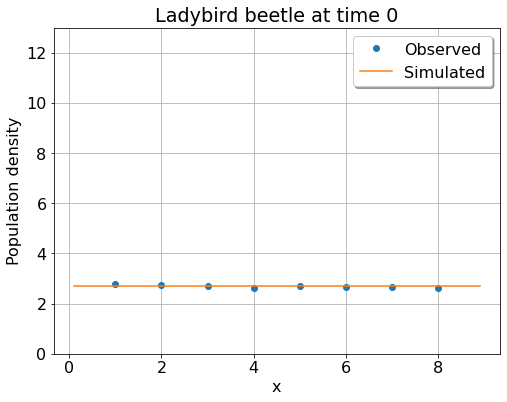

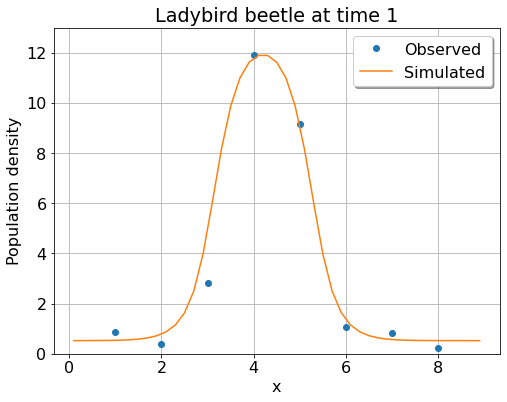

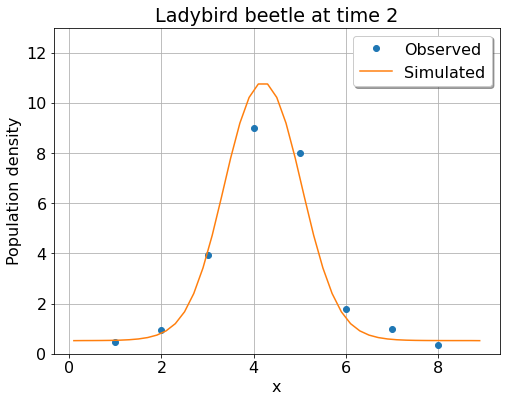

In [18]:
for time_index, ladybeetle_simulation in enumerate(v_storage.data):
    plt.figure(figsize=(8, 6))
    plt.ylim([0, 13])
    
    idx_for_observed = time_labels_dict[time_index]  # we skip time 1/4
    ladybeetle_observed = ladybeetle_data[ladybeetle_data.time == idx_for_observed].copy()
    plt.plot(ladybeetle_observed.x.values, ladybeetle_observed.density.values, 'o', label='Observed')
    plt.plot(x_points, ladybeetle_simulation, '-', label='Simulated')
    
    plt.xlabel('x')
    plt.ylabel('Population density')
    plt.title(f'Ladybird beetle at time {time_index}')
    
    plt.grid(True)
    plt.legend(shadow=True)
    plt.show()